In [1]:
!pip install -q clu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.4.0 which is incompatible.


In [2]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [3]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-13 18:14:26--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-05-13 18:14:26 (17.4 MB/s) - 'input.txt' saved [1115394/1115394]



In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [8]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [11]:
batch_size = 256 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
expans = 3
n_head = 4
channel_size = n_embd // n_head
n_layers = 4
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(256, 64)
[[ 6  1 61 ... 53 50 42]
 [21  1 42 ... 44 47 43]
 [58 46 43 ... 43 56 43]
 ...
 [ 6  0 13 ... 46 53 59]
 [45 56 39 ...  1 41 53]
 [ 1 51 43 ... 57 46 53]]
targets:
(256, 64)
[[ 1 61 46 ... 50 42  0]
 [ 1 42 47 ... 47 43 56]
 [46 43  1 ... 56 43  1]
 ...
 [ 0 13 52 ... 53 59 45]
 [56 39 41 ... 41 53 51]
 [51 43 52 ... 46 53 61]]


In [12]:
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,)) # TODO, maybe use setup will be more clear
        normed = x * jax.lax.rsqrt(np.mean(np.square(x), axis=-1, keepdims=True) + self.eps)
        output = normed * weight
        return output

In [13]:
xb.shape

(256, 64)

In [14]:
class Expan_proj(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=n_embd)(x)
        return x
    
in_proj = nn.Dense(features=n_embd)
params = in_proj.init(rng_key, xb)
in_proj.apply(params, xb).shape

(256, 128)

In [15]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (128,), 'kernel': (64, 128)}}

# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu -->

In [16]:
class MambaBlock(nn.Module):
    
    def setup(self):          
        self.in_proj1 = nn.Dense(features=n_embd * expans)
        self.in_proj2 = nn.Dense(features=n_embd * expans)
        
        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=n_embd * expans,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, n_embd * expans, 1))
        self.B = self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1, n_embd * expans, block_size))
        
        self.out_proj = nn.Dense(n_embd)
        
        self.rms_norm = nn.RMSNorm()
        
    def __call__(self, x):
        
        embeds = x
        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)[1]
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)
        
        x = self.rms_norm(x)
        
        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.C * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        h = 0
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))
        return h, jnp.stack(y, -1)

In [17]:
# model = MambaBlock()
# params = model.init(jax.random.key(0), xb)
# print(model.tabulate(jax.random.key(0), xb,
#                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, xb)
# xb.shape, xs.shape

In [18]:
class Mamba(nn.Module):
    
    def setup(self):
        self.embeddings = nn.Embed(vocab_size, n_embd)
        
        self.mamba_layers = [MambaBlock() for _ in range(n_layers)]
        
    def __call__(self, x):
        x = self.embeddings(x)
        
        for layer in self.mamba_layers:
            x = layer(x)
            
        out = self.embeddings.attend(x)
        return out
    
    @jax.jit
    def generate(self, idx, max_new_tokens, params):
    # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self.apply(params, idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
            # append sampled index to the running sequence
            idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
    #         print(idx_next)
    #         print(idx)

        return idx

In [19]:
class NanoLM(nn.Module):
    """NanoLM model."""
    vocab_size: int = 65
    num_layers: int = 6
    num_heads: int = 8
    head_size: int = 32
    dropout_rate: float = 0.2
    embed_size: int = 256
    block_size: int = 64

    @nn.compact
    def __call__(self, x, training: bool):
        seq_len = x.shape[1]

        x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
            self.block_size, self.embed_size
        )(jnp.arange(seq_len))
        for _ in range(self.num_layers):
            x_norm = nn.LayerNorm()(x)
            x = x + nn.MultiHeadDotProductAttention(
              num_heads=self.num_heads,
              qkv_features=self.head_size,
              out_features=self.head_size * self.num_heads,
              dropout_rate=self.dropout_rate,
            )(
              x_norm,
              x_norm,
              mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
              deterministic=not training,
            )

            x = x + nn.Sequential([
              nn.Dense(4 * self.embed_size),
              nn.relu,
              nn.Dropout(self.dropout_rate, deterministic=not training),
              nn.Dense(self.embed_size),
            ])(nn.LayerNorm()(x))

        x = nn.LayerNorm()(x)
        return nn.Dense(self.vocab_size)(x)

In [20]:
fin_model = Mamba()
fin_params = fin_model.init(jax.random.key(42), xb)
n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
print(f"Total number of parameters: {n_params:_}")
# print(fin_model.tabulate(jax.random.key(42), xb,
#                    compute_flops=True, compute_vjp_flops=True))
xf = fin_model.apply(fin_params, xb)
xb.shape, xf.shape

Total number of parameters: 2_504_320


((256, 64), (256, 64, 65))

In [21]:
# token_gen = generate(jnp.zeros((1,1)).astype(jnp.int32), 100, fin_model, fin_params)
# print(token_gen)
# print(decode(token_gen[0].tolist()))

In [22]:
jax.random.categorical(jax.random.PRNGKey(5332), 1000.0*xf[1][-1][:])

Array(38, dtype=int32)

In [23]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [24]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32))['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [25]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [26]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [27]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [28]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [29]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [30]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results... 
    
      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)
    
    key = (jax.random.split(key)[0])
    
    if (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

  2%|▏         | 100/5000 [01:48<48:35,  1.68it/s]  

train epoch: 100, loss: 3.2150936126708984, accuracy: 18.43878173828125
test epoch: 100, loss: 2.9408440589904785, accuracy: 23.480224609375


  4%|▍         | 200/5000 [02:12<43:38,  1.83it/s]

train epoch: 200, loss: 2.4418559074401855, accuracy: 34.13677978515625
test epoch: 200, loss: 2.114591121673584, accuracy: 41.80908203125


  6%|▌         | 300/5000 [02:36<43:37,  1.80it/s]

train epoch: 300, loss: 1.751853108406067, accuracy: 51.28375244140625
test epoch: 300, loss: 1.5912611484527588, accuracy: 55.6396484375


  8%|▊         | 400/5000 [03:00<42:46,  1.79it/s]

train epoch: 400, loss: 1.2975132465362549, accuracy: 64.08642578125
test epoch: 400, loss: 1.1553611755371094, accuracy: 67.730712890625


 10%|█         | 500/5000 [03:25<41:40,  1.80it/s]

train epoch: 500, loss: 0.9779577255249023, accuracy: 73.2149658203125
test epoch: 500, loss: 0.8976961374282837, accuracy: 75.0


 12%|█▏        | 600/5000 [03:49<40:40,  1.80it/s]

train epoch: 600, loss: 0.8224555253982544, accuracy: 77.23150634765625
test epoch: 600, loss: 0.7973286509513855, accuracy: 77.16064453125


 14%|█▍        | 700/5000 [04:13<39:55,  1.79it/s]

train epoch: 700, loss: 0.6571521759033203, accuracy: 82.00616455078125
test epoch: 700, loss: 0.7800842523574829, accuracy: 78.03955078125


 16%|█▌        | 800/5000 [04:38<39:02,  1.79it/s]

train epoch: 800, loss: 0.5408872961997986, accuracy: 85.03826904296875
test epoch: 800, loss: 0.4886777400970459, accuracy: 86.376953125


 18%|█▊        | 900/5000 [05:02<37:59,  1.80it/s]

train epoch: 900, loss: 0.47699984908103943, accuracy: 87.01470184326172
test epoch: 900, loss: 0.48018914461135864, accuracy: 86.944580078125


 20%|██        | 1000/5000 [05:26<36:55,  1.81it/s]

train epoch: 1000, loss: 0.5342639684677124, accuracy: 85.68437957763672
test epoch: 1000, loss: 0.5440848469734192, accuracy: 84.747314453125


 22%|██▏       | 1100/5000 [05:51<36:11,  1.80it/s]

train epoch: 1100, loss: 0.3904764950275421, accuracy: 89.42583465576172
test epoch: 1100, loss: 0.5797834396362305, accuracy: 84.87548828125


 24%|██▍       | 1200/5000 [06:15<35:18,  1.79it/s]

train epoch: 1200, loss: 0.4224642217159271, accuracy: 88.59490966796875
test epoch: 1200, loss: 0.5209662318229675, accuracy: 86.02294921875


 26%|██▌       | 1300/5000 [06:39<34:23,  1.79it/s]

train epoch: 1300, loss: 0.34477725625038147, accuracy: 90.6270751953125
test epoch: 1300, loss: 0.2684478759765625, accuracy: 92.5048828125


 28%|██▊       | 1400/5000 [07:04<33:29,  1.79it/s]

train epoch: 1400, loss: 0.24953439831733704, accuracy: 93.26873779296875
test epoch: 1400, loss: 0.2762734591960907, accuracy: 92.254638671875


 30%|███       | 1500/5000 [07:28<32:32,  1.79it/s]

train epoch: 1500, loss: 0.2740445137023926, accuracy: 92.7183837890625
test epoch: 1500, loss: 0.258914589881897, accuracy: 93.231201171875


 32%|███▏      | 1600/5000 [07:52<31:40,  1.79it/s]

train epoch: 1600, loss: 0.20543767511844635, accuracy: 94.45733642578125
test epoch: 1600, loss: 0.2001238614320755, accuracy: 94.482421875


 34%|███▍      | 1700/5000 [08:17<30:38,  1.79it/s]

train epoch: 1700, loss: 0.4238026738166809, accuracy: 89.813232421875
test epoch: 1700, loss: 0.45087581872940063, accuracy: 87.95166015625


 36%|███▌      | 1800/5000 [08:41<29:39,  1.80it/s]

train epoch: 1800, loss: 0.29244938492774963, accuracy: 92.0040283203125
test epoch: 1800, loss: 0.23722659051418304, accuracy: 93.44482421875


 38%|███▊      | 1900/5000 [09:05<28:51,  1.79it/s]

train epoch: 1900, loss: 0.20694129168987274, accuracy: 94.385498046875
test epoch: 1900, loss: 0.20008015632629395, accuracy: 94.42138671875


 40%|████      | 2000/5000 [09:30<27:55,  1.79it/s]

train epoch: 2000, loss: 0.24242530763149261, accuracy: 93.7926025390625
test epoch: 2000, loss: 0.3748420476913452, accuracy: 90.374755859375


 42%|████▏     | 2100/5000 [09:54<26:54,  1.80it/s]

train epoch: 2100, loss: 0.3432295620441437, accuracy: 91.666259765625
test epoch: 2100, loss: 0.35111474990844727, accuracy: 90.972900390625


 44%|████▍     | 2200/5000 [10:18<25:59,  1.80it/s]

train epoch: 2200, loss: 0.34274911880493164, accuracy: 91.5806884765625
test epoch: 2200, loss: 0.28607177734375, accuracy: 92.291259765625


 46%|████▌     | 2300/5000 [10:43<24:58,  1.80it/s]

train epoch: 2300, loss: 0.21936321258544922, accuracy: 94.20207977294922
test epoch: 2300, loss: 0.20237787067890167, accuracy: 94.54345703125


 48%|████▊     | 2400/5000 [11:07<24:05,  1.80it/s]

train epoch: 2400, loss: 0.29064851999282837, accuracy: 92.8099365234375
test epoch: 2400, loss: 0.34788283705711365, accuracy: 90.771484375


 50%|█████     | 2500/5000 [11:31<23:10,  1.80it/s]

train epoch: 2500, loss: 0.32444900274276733, accuracy: 91.717041015625
test epoch: 2500, loss: 0.43999457359313965, accuracy: 88.8427734375


 52%|█████▏    | 2600/5000 [11:56<22:18,  1.79it/s]

train epoch: 2600, loss: 0.4166741967201233, accuracy: 89.31475830078125
test epoch: 2600, loss: 0.3912495970726013, accuracy: 89.495849609375


 54%|█████▍    | 2700/5000 [12:20<21:20,  1.80it/s]

train epoch: 2700, loss: 0.33768972754478455, accuracy: 91.326171875
test epoch: 2700, loss: 0.3669545650482178, accuracy: 90.56396484375


 56%|█████▌    | 2800/5000 [12:45<20:24,  1.80it/s]

train epoch: 2800, loss: 0.26260700821876526, accuracy: 93.0838623046875
test epoch: 2800, loss: 0.22396498918533325, accuracy: 93.914794921875


 58%|█████▊    | 2900/5000 [13:09<19:28,  1.80it/s]

train epoch: 2900, loss: 0.18124839663505554, accuracy: 95.19024658203125
test epoch: 2900, loss: 0.1623554527759552, accuracy: 95.465087890625


 60%|██████    | 3000/5000 [13:33<18:27,  1.81it/s]

train epoch: 3000, loss: 0.3860538899898529, accuracy: 90.5648193359375
test epoch: 3000, loss: 0.4392067790031433, accuracy: 88.63525390625


 62%|██████▏   | 3100/5000 [13:57<17:33,  1.80it/s]

train epoch: 3100, loss: 0.33226194977760315, accuracy: 91.2205810546875
test epoch: 3100, loss: 0.35919344425201416, accuracy: 90.5029296875


 64%|██████▍   | 3200/5000 [14:22<16:41,  1.80it/s]

train epoch: 3200, loss: 0.24372674524784088, accuracy: 93.4273681640625
test epoch: 3200, loss: 0.2195586860179901, accuracy: 93.939208984375


 66%|██████▌   | 3300/5000 [14:46<15:46,  1.80it/s]

train epoch: 3300, loss: 0.16839861869812012, accuracy: 95.36406707763672
test epoch: 3300, loss: 0.1632196009159088, accuracy: 95.4345703125


 68%|██████▊   | 3400/5000 [15:10<14:53,  1.79it/s]

train epoch: 3400, loss: 0.14038406312465668, accuracy: 96.19512939453125
test epoch: 3400, loss: 0.14375701546669006, accuracy: 96.044921875


 70%|███████   | 3500/5000 [15:35<13:53,  1.80it/s]

train epoch: 3500, loss: 0.13789643347263336, accuracy: 96.23895263671875
test epoch: 3500, loss: 0.13644751906394958, accuracy: 96.282958984375


 72%|███████▏  | 3600/5000 [15:59<12:54,  1.81it/s]

train epoch: 3600, loss: 0.12031683325767517, accuracy: 96.74713134765625
test epoch: 3600, loss: 0.14586928486824036, accuracy: 96.234130859375


 74%|███████▍  | 3700/5000 [16:23<12:00,  1.81it/s]

train epoch: 3700, loss: 0.1109742522239685, accuracy: 96.9942626953125
test epoch: 3700, loss: 0.11434675753116608, accuracy: 96.990966796875


 76%|███████▌  | 3800/5000 [16:48<11:05,  1.80it/s]

train epoch: 3800, loss: 0.13400867581367493, accuracy: 96.52862548828125
test epoch: 3800, loss: 0.14540645480155945, accuracy: 96.19140625


 78%|███████▊  | 3900/5000 [17:12<10:11,  1.80it/s]

train epoch: 3900, loss: 0.1259818971157074, accuracy: 96.69219970703125
test epoch: 3900, loss: 0.14623332023620605, accuracy: 95.83740234375


 80%|████████  | 4000/5000 [17:36<09:12,  1.81it/s]

train epoch: 4000, loss: 0.15658169984817505, accuracy: 95.91338348388672
test epoch: 4000, loss: 0.16138336062431335, accuracy: 95.880126953125


 82%|████████▏ | 4100/5000 [18:00<08:20,  1.80it/s]

train epoch: 4100, loss: 0.12251684069633484, accuracy: 96.88616943359375
test epoch: 4100, loss: 0.4364866614341736, accuracy: 91.448974609375


 84%|████████▍ | 4200/5000 [18:25<07:25,  1.80it/s]

train epoch: 4200, loss: 0.2379787266254425, accuracy: 94.1651611328125
test epoch: 4200, loss: 0.1274152547121048, accuracy: 96.551513671875


 86%|████████▌ | 4300/5000 [18:49<06:27,  1.80it/s]

train epoch: 4300, loss: 0.20304377377033234, accuracy: 95.175048828125
test epoch: 4300, loss: 0.1778634786605835, accuracy: 95.367431640625


 88%|████████▊ | 4400/5000 [19:13<05:34,  1.80it/s]

train epoch: 4400, loss: 0.27790430188179016, accuracy: 93.50908660888672
test epoch: 4400, loss: 0.25164610147476196, accuracy: 93.39599609375


 90%|█████████ | 4500/5000 [19:38<04:38,  1.80it/s]

train epoch: 4500, loss: 0.14460833370685577, accuracy: 96.15752410888672
test epoch: 4500, loss: 0.12734568119049072, accuracy: 96.71630859375


 92%|█████████▏| 4600/5000 [20:02<03:41,  1.80it/s]

train epoch: 4600, loss: 0.12954749166965485, accuracy: 96.6065673828125
test epoch: 4600, loss: 0.10854381322860718, accuracy: 97.052001953125


 94%|█████████▍| 4700/5000 [20:26<02:46,  1.81it/s]

train epoch: 4700, loss: 0.12751013040542603, accuracy: 96.79327392578125
test epoch: 4700, loss: 0.12298130244016647, accuracy: 96.551513671875


 96%|█████████▌| 4800/5000 [20:50<01:51,  1.80it/s]

train epoch: 4800, loss: 0.10321743786334991, accuracy: 97.25909423828125
test epoch: 4800, loss: 0.1076260507106781, accuracy: 96.978759765625


 98%|█████████▊| 4900/5000 [21:15<00:55,  1.80it/s]

train epoch: 4900, loss: 0.1214924082159996, accuracy: 96.91864013671875
test epoch: 4900, loss: 0.13397382199764252, accuracy: 96.25244140625


100%|██████████| 5000/5000 [21:39<00:00,  3.85it/s]

train epoch: 5000, loss: 0.12169346213340759, accuracy: 96.75237274169922
test epoch: 5000, loss: 0.19788479804992676, accuracy: 95.245361328125


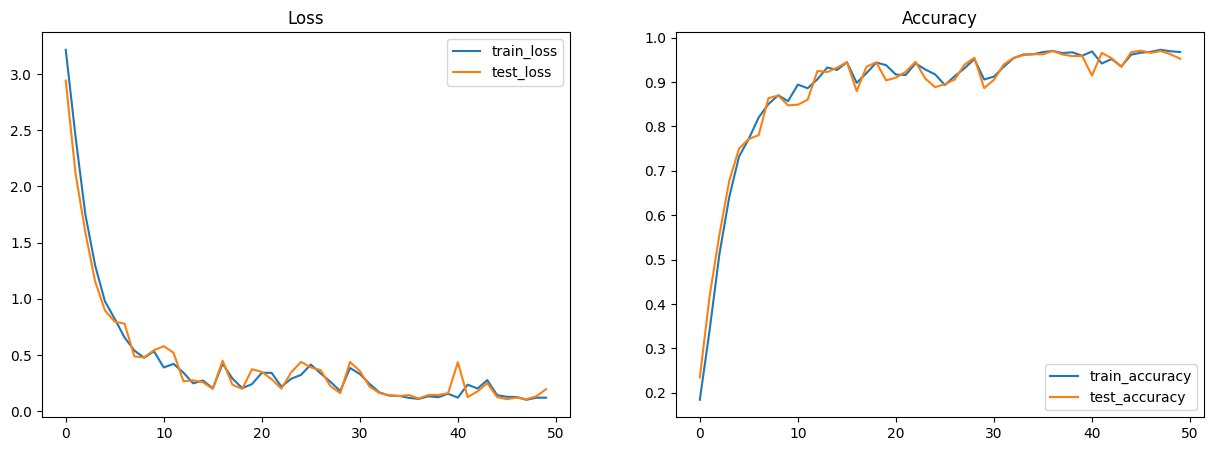

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [32]:

logits = fin_model.apply(fin_params, xb)
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

4.658183


In [33]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)
            
#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)

        
#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx

In [34]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context)
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

/opt/conda/lib/python3.10/site-packages/jax/_src/api_util.py:231: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [35]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[24, 33, 25, 24, 0, 20, 23, 10, 0, 19, 53, 53, 50, 52, 1, 57, 52, 1, 51, 39, 63, 1, 60, 53, 60, 43, 56, 43, 57, 1, 57, 50, 59, 50, 46, 0, 13, 27, 30, 21, 23, 30, 21, 19, 15, 2, 17, 32, 10, 32, 21, 21, 18, 44, 1, 21, 30, 26, 45, 17, 53, 50, 50, 10, 0, 32, 46, 53, 59, 56, 56, 53, 53, 61, 6, 1, 54, 53, 57, 58, 53, 1, 58, 46, 43, 0, 1, 21, 0, 18, 21, 10, 24, 0, 25, 17, 27, 37, 50, 47, 56, 57, 43, 12, 0, 32, 39, 57, 1, 40, 53, 51, 43, 1, 40, 53, 59, 50, 50, 7, 1, 61, 46, 39, 50, 1, 46, 59, 54, 1, 40, 43, 57, 1, 63, 53, 59, 57, 6, 0, 18, 21, 24, 1, 10, 1, 47, 42, 46, 1, 51, 59, 41, 49, 51, 39, 45, 57, 1, 21, 47, 50, 42, 57, 8, 0, 0, 18, 1, 24, 13, 32, 24, 21, 19, 13, 32, 30, 18, 1, 30, 47, 51, 43, 43, 42, 1, 40, 59, 40, 43, 57, 1, 63, 53, 59, 1, 53, 44, 1, 47, 52, 0, 40, 43, 1, 58, 53, 59, 1, 46, 43, 39, 58, 43, 42, 6, 1, 44, 53, 59, 56, 57, 43, 1, 58, 46, 43, 39, 56, 56, 43, 6, 1, 53, 60, 43, 57, 1, 57, 54, 43, 39, 50, 43, 47, 52, 6, 1, 39, 42, 1, 53, 60, 46, 53, 52, 1, 59, 47, 56, 42, 53, 

In [36]:
print(decode(token_gen))

LUML
HK:
Gooln sn may voveres slulh
AORIKRIGC!ET:TIIFf IRNgEoll:
Thourroow, posto the
 I
FI:L
MEOYlirse?
Tas bome boull- whal hup bes yous,
FIL : idh muckmags Iilds.

F LATLIGATRF Rimeed bubes you of in
be tou heated, fourse thearre, oves spealein, ad ovhon uirdown popler thers ealdell at begs denarryilht yetghe ds
:A
PETyt ki hargey loce tinfIANtEorne beme, wthe, heatham a bes thioherron?

NMUCLORCERFsEy: yerleav?
IR EOAI:
 you.

IEAELARORMAMUEGE
CFfI:ATUG:Ret shoue evis pau my is.

YBULIDGERR:C.N
A REL

TDons ces iw thes
IN ORYORETCyIEREON R La st rolor ahd?
Tyouths tef I
MVorn
HANf: bur whe hon aur fo soirhousteat sus sunn gile ghy bt' pas:
HPGNyIid gouk,es
WYrle shour sple is Ry: no delay,
O I housr ble yu nos thawe if aw:
TIVring fhuo sTt, meerdpyerf thoudfI gims.

OA
Auy
IECmA Rhe, dirch heellcemy idalul.

D
Neqees bacalt heiof wheito oomy go pe theeise a and'd etacpfe, Pa hat dof we eece ret bemes beut hall ho ceau haes bilss st; bindy xey d' toul humee may yountewn aflat gh's t

In [37]:
att_model = NanoLM(
    vocab_size=vocab_size,
    num_layers=4,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=256,
    block_size=64,
)

var_params = att_model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)

n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

Total number of parameters: 2_289_089


In [38]:
jax.random.categorical(jax.random.PRNGKey(100), jnp.array([10.0,-10.0,-10.0,10.0,-11.0,-11.0,-11.0,-100.0,-1000]))

Array(3, dtype=int32)

In [39]:
logitss = state.apply_fn({'params': state.params}, (43*jnp.zeros((1,1))).astype(jnp.int32))[:,-1,:]

In [40]:
token_gen[:,-32:]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
print("gen text: ",print(decode(token_gen[0].tolist())), "end of text")

In [ ]:
jax.random.randint(jax.random.PRNGKey(52), (1,32), minval, maxval

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np

logitss = state.apply_fn({'params': state.params}, xbb[0].reshape(1,32))[:,-1,:]

probs = F.softmax(torch.from_numpy(np.asarray(logitss)), dim=-1) # (B, C)
# sample from the distribution
idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
idx_next

In [ ]:
state.tx.